In [16]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline

In [37]:
#Bokeh imports
from bokeh.io import output_file, output_notebook, show
from bokeh.plotting import figure, ColumnDataSource
#Using output notebook to display in JupyterNotebook
output_notebook()

#Interactive map imports
from bokeh.models import (
    Range1d,
    GeoJSONDataSource,
    HoverTool,
    LinearColorMapper,
    GMapPlot, GMapOptions, ColumnDataSource, 
    Circle, DataRange1d, PanTool, WheelZoomTool, BoxSelectTool
)

Loading BokehJS ...

## Introduction to Bokeh

Text(113.23049338868236, 0.5, 'Latitude')

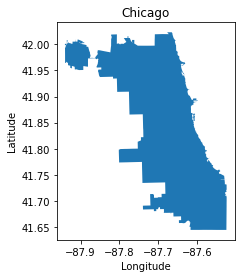

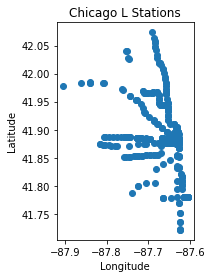

In [48]:
Chi = gpd.read_file('chicago.geojson')
L_Stations = gpd.read_file('cta_entrances.geojson')

#Separate plots for Chicago and its L stations
Chi.plot()
plt.title('Chicago')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

L_Stations.plot()
plt.title('Chicago L Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Text(109.69662474320302, 0.5, 'Latitude')

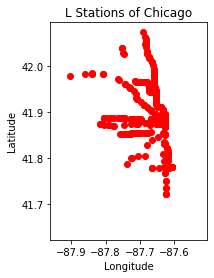

In [49]:
'''
base_map shows a black outline for the tutorial, 
but updates to matplotlib likely changed using a white colo
'''
base_map = Chi.plot(color='white')
L_Stations.plot(ax=base_map,color='red')
plt.title('L Stations of Chicago')
plt.xlabel('Longitude')
plt.ylabel('Latitude')


The data is plotted properly and is marked with useful axis names and data, but an interactive map would give a better look by allowing for zoom and L station information (is there anything unique about a particular L station?). Bokeh is a solution to this issue.

Need to convert the geometry data to "column-like lists" that Bokeh can read

In [50]:
def convert_GeoPandas_to_Bokeh_format(gdf):
    """
    Function to convert a GeoPandas GeoDataFrame to a Bokeh
    ColumnDataSource object.
    
    :param: (GeoDataFrame) gdf: GeoPandas GeoDataFrame with polygon(s) under
                                the column name 'geometry.'
                                
    :return: ColumnDataSource for Bokeh.
    """
    gdf_new = gdf.drop('geometry', axis=1).copy()
    gdf_new['x'] = gdf.apply(getGeometryCoords, 
                             geom='geometry', 
                             coord_type='x', 
                             shape_type='polygon', 
                             axis=1)
    
    gdf_new['y'] = gdf.apply(getGeometryCoords, 
                             geom='geometry', 
                             coord_type='y', 
                             shape_type='polygon', 
                             axis=1)
    
    return ColumnDataSource(gdf_new)


def getGeometryCoords(row, geom, coord_type, shape_type):
    """
    Returns the coordinates ('x' or 'y') of edges of a Polygon exterior.
    
    :param: (GeoPandas Series) row : The row of each of the GeoPandas DataFrame.
    :param: (str) geom : The column name.
    :param: (str) coord_type : Whether it's 'x' or 'y' coordinate.
    :param: (str) shape_type
    """
    
    # Parse the exterior of the coordinate
    if shape_type == 'polygon':
        exterior = row[geom].geoms[0].exterior
        if coord_type == 'x':
            # Get the x coordinates of the exterior
            return list( exterior.coords.xy[0] )    
        
        elif coord_type == 'y':
            # Get the y coordinates of the exterior
            return list( exterior.coords.xy[1] )

    elif shape_type == 'point':
        exterior = row[geom]
    
        if coord_type == 'x':
            # Get the x coordinates of the exterior
            return  exterior.coords.xy[0][0] 

        elif coord_type == 'y':
            # Get the y coordinates of the exterior
            return  exterior.coords.xy[1][0]

In [39]:
#Data exists as one item dataframe with points and polygons inside of it
Chi.head()

,geometry
0,"MULTIPOLYGON (((-87.66421 42.02126, -87.66419 ..."


In [51]:
#Conversion of Chicago map
Chi_Source = convert_GeoPandas_to_Bokeh_format(Chi)
p = figure(title="Chicago")
p.multi_line('x', 'y', source=Chi_Source, color="black", line_width=2)
show(p)

In [52]:
#More readable DF, but information we want is still hidden within a Point in the geometry column
L_Stations.head()

,name,agency,line,geometry
0,18th,CTA,Pink Line,POINT (-87.66914 41.85785)
1,35th/Archer,CTA,Orange Line,POINT (-87.68063 41.82927)
2,95th-Dan Ryan,CTA,Red Line,POINT (-87.62441 41.72273)
3,Adams/Wabash,CTA,"Brown, Purple, Orange, Pink, Green Lines",POINT (-87.62600 41.87971)
4,Addison,CTA,Blue Line,POINT (-87.71841 41.94660)


In [53]:
#SLight variation of Geopandas to Bokeh conversion method
L_Stations['x'] = L_Stations.apply(getGeometryCoords, 
                                 geom='geometry', 
                                 coord_type='x', 
                                 shape_type='point',
                                 axis=1)
                                 
L_Stations['y'] = L_Stations.apply(getGeometryCoords, 
                                 geom='geometry', 
                                 coord_type='y', 
                                 shape_type='point',
                                 axis=1)

L_Stations = L_Stations.drop(['geometry','agency'],axis=1)

In [54]:
#Now converted to x and y
L_Stations.head()

,name,line,x,y
0,18th,Pink Line,-87.669144,41.857849
1,35th/Archer,Orange Line,-87.680632,41.829274
2,95th-Dan Ryan,Red Line,-87.624410,41.722729
3,Adams/Wabash,"Brown, Purple, Orange, Pink, Green Lines",-87.625997,41.879715
4,Addison,Blue Line,-87.718406,41.946604


In [57]:
#Create new ColumnDataSource
L_Source = ColumnDataSource(data=dict(x=L_Stations['x'],
                                      y=L_Stations['y'],
                                      line=L_Stations['line'].values,
                                      name=L_Stations['name'].values))


In [62]:
'''Overlay Map Configuration'''

#Set overlay map tools
TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save" 
#Empty base figure with included tools
Elevated = figure(title="Chicago \'L\' System", 
                tools=TOOLS,
                x_axis_location=None, 
                y_axis_location=None) 
#Base chicago plot
Elevated.multi_line('x', 
                    'y', 
                    source=Chi_Source, 
                    color="black", 
                    line_width=2)
#L station plot
Elevated.circle('x', 
                'y', 
                source=L_Source, 
                size=4)

#Interactive hover config
hover = Elevated.select_one(HoverTool)
hover.point_policy = "follow_mouse"
#Shown as tuples. The hover tool applies to all data points, 
#but name and line are not valid for non-L station points, so
#they are shown as "???"
hover.tooltips = [
        ("Name", "@name"),
        ("Line.", "@line"),
        ("(Long, Lat)", "($x, $y)"),
        ]

#Display graph
show(Elevated)

## Extended Example

While our example of an NFL ELO tracker definitely "worked" in Seaborn, we could easily see that plotting ELO for all games since 1920 is rather resource intensive, since including only 3 teams with about 400 games per team took over 10 seconds to display all graphs. Let us see if Bokeh can do this faster while adding a bit of functionality.

In [84]:
#Ported ELO tracker code
import numpy as np
from datetime import datetime as dt
url = "https://raw.githubusercontent.com/fivethirtyeight/nfl-elo-game/"
url += "3488b7d0b46c5f6583679bc40fb3a42d729abd39/data/nfl_games.csv"
df = pd.read_csv(url, index_col=0)

#Put teams you want here
teams = ["RII", "ATL", "NE"]

data = df[((df["team1"].isin(teams)) |
          (df["team2"].isin(teams)))]

for team in teams:
    #Grabbing elo depending on whether it is team or team 2
    elo_table = df.loc[df['team1'] == team]['elo1']
    elo_table.append(df.loc[df['team2'] == team]['elo2'])
    elo_table.sort_index()
    elo_table.index = pd.to_datetime(elo_table.index)
    p = figure(title=f"{team} Historical ELO", x_axis_label="Year", y_axis_label="ELO", x_axis_type="datetime")
    p.line(elo_table.index.values, elo_table.values, line_width=2)
    show(p)

A much faster and nicer looking visual! Do note, however, that while Seaborn is slower for larger datasets, it is arguably more intuitive and simpler to get started on.